# Key Takeaways

Chapter 10 of Wes McKinney's [*Python for Data Analysis*](https://wesmckinney.com/pages/book.html) discusses groupby operations, which are the pandas equivalent of Excel pivot tables.
Pivot tables help us calculate statistics (e.g., sum, mean, and median) for one set of variables by groups of other variables (e.g., weekday or year).
For example, we could use a pivot table to calculate mean daily stock returns by weekday.

***The key takeaways from this notebook are:***

1. Using the `.groupby()` method
1. Grouping with columns, indexes, and functions
1. Using `.agg()` to aggregate multiple functions
1. Using pivot tables as an alternative to the `.groupby()` method

***Note:*** Indented block quotes are from McKinney, and section numbers differ from McKinney because we will not discuss every topic.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.dpi'] = 150
np.set_printoptions(precision=4, suppress=True)
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import requests_cache
session = requests_cache.CachedSession()
import yfinance as yf
import pandas_datareader as pdr

# GroupBy Mechanics

"Split-apply-combine" is an excellent way to describe and visualize pandas groupby operations.

> Hadley Wickham, an author of many popular packages for the R programming 
language, coined the term split-apply-combine for describing group operations. In the
first stage of the process, data contained in a pandas object, whether a Series, DataFrame, or otherwise, is split into groups based on one or more keys that you provide.
The splitting is performed on a particular axis of an object. For example, a DataFrame
can be grouped on its rows (axis=0) or its columns (axis=1). Once this is done, a
function is applied to each group, producing a new value. Finally, the results of all
those function applications are combined into a result object. The form of the resulting object will usually depend on what’s being done to the data. See Figure 10-1 for a
mockup of a simple group aggregation.

Figure 10-1 visualizes a pandas groupby operation that:

1. Splits the dataframe by the `key` column (i.e., "groups by `key`")
2. Applies the sum operation to the `data` column (i.e., "sums `data`")
3. Combines the grouped sums

I describe this operation as "sum the `data` column by (gruops formed on) the `key` column."

In [4]:
np.random.seed(42)
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})

In [5]:
df

,key1,key2,data1,data2
0,a,one,0.4967,-0.2341
1,a,two,-0.1383,1.5792
2,b,one,0.6477,0.7674
3,b,two,1.5230,-0.4695
4,a,one,-0.2342,0.5426


Here is one way to calculate the means of `data1` by (grouops formed on) `key1`.

In [6]:
df.loc[df['key1'] == 'a', 'data1'].mean()

0.041432159038904015

In [7]:
df.loc[df['key1'] == 'b', 'data1'].mean()

1.085359197254359

We can do this calculation more quickly:

1. Use the `.groupby()` method to group by `key1`
2. Use the `.mean()` method to sum `data1` within each value of `key1`

Note that without the `.mean()` method, pandas only sets up the grouped object, which can later accept the `.mean()` method.

In [8]:
grouped = df['data1'].groupby(df['key1'])

In [9]:
grouped

In [10]:
grouped.mean()

key1
a   0.0414
b   1.0854
Name: data1, dtype: float64

We can can chain the `.groupby()` and `.mean()` methods.

In [11]:
df['data1'].groupby(df['key1']).mean()

key1
a   0.0414
b   1.0854
Name: data1, dtype: float64

If we prefer our result as a dataframe instead of a series, we can wrap `data1` with two sets of square brackets.

In [12]:
df[['data1']].groupby(df['key1']).mean()

,data1
key1,
a,0.0414
b,1.0854


We can group by more than one variable.
We get a hierarchical row index (or row multi-index) when we group by more than one variable.

In [13]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one     0.1313
      two    -0.1383
b     one     0.6477
      two     1.5230
Name: data1, dtype: float64

We can use the `.unstack()` method if we want to use both rows and columns to organize data.
Note that, the `.unstack()` method un-stacks the last dimension (i.e., `level = -1`) by default so that `key2` values become columns.

In [14]:
means.unstack()

key2,one,two
key1,,
a,0.1313,-0.1383
b,0.6477,1.5230


The grouping variables can also be columns in the data frame passed to the `.groupby()` method.
I prefer this approach because we will typically have all data in one data frame.

In [15]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,0.0414,0.6292
b,1.0854,0.1490


In [16]:
df.groupby(['key1', 'key2']).mean()

data1   data2
key1 key2                
a    one   0.1313  0.1542
     two  -0.1383  1.5792
b    one   0.6477  0.7674
     two   1.5230 -0.4695

There are many more methods than `.mean()`.
We can use tab completion to discover (or remind ourselves of) these other methods.

---

***Practice:***
Calculate the means of columns `data1` and `data2` by `key1` and `key2`, and arrange the results so that values of `key1` are in the rows and values of `key2` are in the columns.

In [17]:
df.groupby(['key1', 'key2']).mean().unstack()

data1          data2        
key2    one     two    one     two
key1                              
a    0.1313 -0.1383 0.1542  1.5792
b    0.6477  1.5230 0.7674 -0.4695

***Practice:***
Replicate the previous practice exercise with `pd.pivot_table()` and test equality with `np.allclose()`.
We will learn more about `pd.pivot_table()` at the end of this notebook, but we can give it a try now.

In [18]:
pd.pivot_table(data=df, index='key1', columns='key2')

data1          data2        
key2    one     two    one     two
key1                              
a    0.1313 -0.1383 0.1542  1.5792
b    0.6477  1.5230 0.7674 -0.4695

If we want to apply a pandas method, wrap it in quotes.

In [19]:
pd.pivot_table(data=df, index='key1', columns='key2', aggfunc=['mean', 'median'])

mean                        median                       
      data1          data2          data1          data2        
key2    one     two    one     two    one     two    one     two
key1                                                            
a    0.1313 -0.1383 0.1542  1.5792 0.1313 -0.1383 0.1542  1.5792
b    0.6477  1.5230 0.7674 -0.4695 0.6477  1.5230 0.7674 -0.4695

---

## Iterating Over Groups

We can iterate over groups, too.
The `.groupby()` method generates a sequence of tuples.
Each tuples contains the value(s) of the grouping variable(s) and associated chunk of the dataframe.
McKinney provides two loops to show how to iterate over groups.

In [20]:
df

,key1,key2,data1,data2
0,a,one,0.4967,-0.2341
1,a,two,-0.1383,1.5792
2,b,one,0.6477,0.7674
3,b,two,1.5230,-0.4695
4,a,one,-0.2342,0.5426


In [21]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

a
  key1 key2   data1   data2
0    a  one  0.4967 -0.2341
1    a  two -0.1383  1.5792
4    a  one -0.2342  0.5426
b
  key1 key2  data1   data2
2    b  one 0.6477  0.7674
3    b  two 1.5230 -0.4695


In [22]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
  key1 key2   data1   data2
0    a  one  0.4967 -0.2341
4    a  one -0.2342  0.5426
('a', 'two')
  key1 key2   data1  data2
1    a  two -0.1383 1.5792
('b', 'one')
  key1 key2  data1  data2
2    b  one 0.6477 0.7674
('b', 'two')
  key1 key2  data1   data2
3    b  two 1.5230 -0.4695


We can also group over columns (i.e., `axis = 1`), but this grouping is less common.

## Selecting a Column or Subset of Columns

We preview the idea of grouping an entire dataframe above.
However, I want to take this chance to explain McKinney's use of the phrase "syntactic sugar."
Here is the context:

> Indexing a GroupBy object created from a DataFrame with a column name or array
of column names has the effect of column subsetting for aggregation. This means
that:
>
>     df.groupby('key1')['data1']
>     df.groupby('key1')[['data2']]
>
> are syntactic sugar for
>
>     df['data1'].groupby(df['key1'])
>     df[['data2']].groupby(df['key1'])

"Syntactic sugar" makes code easier to type or read without adding functionality.
It makes code "sweeter" for humans to type or read by making it more concise or clear.
The implication is that syntactic sugar makes code faster to type/read but does make code faster to execute.

In [23]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2        
a    one   0.1542
     two   1.5792
b    one   0.7674
     two  -0.4695

## Grouping with Functions

We can also group with functions.
Below, we group with the `len` function, which calculates the length of the first names in the row index.
We could instead add a helper column to `people`, but it is easier to pass a function to `.groupby()`.

In [24]:
np.random.seed(42)
people = pd.DataFrame(
    data=np.random.randn(5, 5), 
    columns=['a', 'b', 'c', 'd', 'e'], 
    index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis']
)

In [25]:
people

,a,b,c,d,e
Joe,0.4967,-0.1383,0.6477,1.5230,-0.2342
Steve,-0.2341,1.5792,0.7674,-0.4695,0.5426
Wes,-0.4634,-0.4657,0.2420,-1.9133,-1.7249
Jim,-0.5623,-1.0128,0.3142,-0.9080,-1.4123
Travis,1.4656,-0.2258,0.0675,-1.4247,-0.5444


In [26]:
people.groupby(len).sum()

,a,b,c,d,e
3,-0.5290,-1.6168,1.2039,-1.2983,-3.3714
5,-0.2341,1.5792,0.7674,-0.4695,0.5426
6,1.4656,-0.2258,0.0675,-1.4247,-0.5444


---

***Practice:***
Calculate the sum of columns a through e by groups formed on the last letter in each name.
*Hint:* use an anonymous (lambda) function.

In [27]:
'Matilda'[-1]

'a'

In [28]:
def last_letter(x):
	return x[-1]

In [29]:
last_letter('Matilda')

'a'

In [30]:
last_letter = lambda x: x[-1]

In [31]:
last_letter('Matilda')

'a'

In [32]:
people.groupby(lambda x: x[-1]).sum()

,a,b,c,d,e
e,0.2626,1.4409,1.4151,1.0536,0.3084
m,-0.5623,-1.0128,0.3142,-0.9080,-1.4123
s,1.0022,-0.6915,0.3095,-3.3380,-2.2693


We could also, do the following:

In [33]:
ll = lambda x: x[-1]

In [34]:
people.groupby(ll).sum()

,a,b,c,d,e
e,0.2626,1.4409,1.4151,1.0536,0.3084
m,-0.5623,-1.0128,0.3142,-0.9080,-1.4123
s,1.0022,-0.6915,0.3095,-3.3380,-2.2693


***Practice:***
Use the `.to_clipboard()` method to check the previous practice exercise in Excel.

---

We can mix functions, lists, etc. that we pass to `.groupby()`.

In [35]:
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

a       b      c       d       e
3 one -0.4634 -0.4657 0.2420 -1.9133 -1.7249
  two -0.5623 -1.0128 0.3142 -0.9080 -1.4123
5 one -0.2341  1.5792 0.7674 -0.4695  0.5426
6 two  1.4656 -0.2258 0.0675 -1.4247 -0.5444

In [36]:
d = {'Joe': 'a', 'Jim': 'b'}
people.groupby([len, d]).min()

a       b      c       d       e
3 a  0.4967 -0.1383 0.6477  1.5230 -0.2342
  b -0.5623 -1.0128 0.3142 -0.9080 -1.4123

## Grouping by Index Levels

We can also group by index levels.
We can specify index levels by either level number or name.

In [37]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                    [1, 3, 5, 1, 3]],
                                    names=['cty', 'tenor'])
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)

In [38]:
hier_df

cty        US                      JP        
tenor       1       3       5       1       3
0      0.1109 -1.1510  0.3757 -0.6006 -0.2917
1     -0.6017  1.8523 -0.0135 -1.0577  0.8225
2     -1.2208  0.2089 -1.9597 -1.3282  0.1969
3      0.7385  0.1714 -0.1156 -0.3011 -1.4785

In [39]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


In [40]:
hier_df.groupby(level='cty', axis='columns').count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


In [41]:
hier_df.groupby(level='tenor', axis=1).count()

tenor,1,3,5
0,2,2,1
1,2,2,1
2,2,2,1
3,2,2,1


# Data Aggregation

Table 10-1 provides the optimized groupby methods:

- `count`: Number of non-NA values in the group
- `sum`: Sum of non-NA values
- `mean`: Mean of non-NA values
- `median`: Arithmetic median of non-NA values
- `std`, `var`: Unbiased (n – 1 denominator) standard deviation and variance
- `min`, `max`: Minimum and maximum of non-NA values
- `prod`: Product of non-NA values
- `first`, `last`: First and last non-NA values

These optimized methods are fast and efficient, but pandas does not limit us to these methods.
First, any series method is available.

In [42]:
df.groupby('key1')['data1'].quantile(0.9)

key1
a   0.3697
b   1.4355
Name: data1, dtype: float64

Second, we can write our own functions and pass them to the `.agg()` method.
These functions should accept an array and returns a single value.

In [43]:
def peak_to_peak(arr):
    return arr.max() - arr.min()

In [44]:
df.groupby('key1')['data1'].agg(peak_to_peak)

key1
a   0.7309
b   0.8753
Name: data1, dtype: float64

Some other methods work, too, even if they are do not aggregate an array to a single value.

In [45]:
df.groupby('key1')['data1'].describe()

,count,mean,std,min,25%,50%,75%,max
key1,,,,,,,,
a,3.0000,0.0414,0.3972,-0.2342,-0.1862,-0.1383,0.1792,0.4967
b,2.0000,1.0854,0.6190,0.6477,0.8665,1.0854,1.3042,1.5230


In [46]:
df.groupby('key1').describe().stack(level=0) # here the level arguments describes the outer column index

25%     50%    75%  count    max   mean     min    std
key1                                                                 
a    data1 -0.1862 -0.1383 0.1792 3.0000 0.4967 0.0414 -0.2342 0.3972
     data2  0.1542  0.5426 1.0609 3.0000 1.5792 0.6292 -0.2341 0.9098
b    data1  0.8665  1.0854 1.3042 2.0000 1.5230 1.0854  0.6477 0.6190
     data2 -0.1602  0.1490 0.4582 2.0000 0.7674 0.1490 -0.4695 0.8746

## Column-Wise and Multiple Function Application

The `.agg()` methods provides two more handy features:

1. We can pass multiple functions to operate on all of the columns
2. We can pass specific functions to operate on specific columns

---

We will use the same data for a handful of practice exercises with the `.agg()` method.
The following code download daily market data for the FAANG stocks, adds daily returns, and reshapes to long.

In [47]:
faang = yf.download(tickers='FB AAPL AMZN NFLX GOOG', session=session)
faang[pd.MultiIndex.from_product([['Return'], faang['Adj Close'].columns])] = faang['Adj Close'].pct_change()
faang = faang.stack()
faang.index.names = ['Date', 'Ticker']
faang.columns.names = ['Variable']

[*********************100%***********************]  5 of 5 completed


***Practice:***
Calulate the mean and standard deviation of returns by ticker.

***Practice:***
Calulate the mean and standard deviation of returns and the maximum of closing prices by ticker.
To do this, pass a dictionary where the keys are the column names and the values are lists of functions.

---

## Returning Aggregated Data Without Row Indexes

The `.groupby()` method returns the grouping variable(s) and row (or column) index(es).
These indexes are often helpful, but sometimes frustrating.
We can use the `as_index=False` argument to keep the grouping variables as columns.

# Apply: General split-apply-combine

The `.agg()` method aggrates an array to a single value.
We can use the `.apply()` method for more general calculations.

We can combine the `.groupby()` and `.apply()` methods to:

1. Split a dataframe by grouping variables
2. Call the applied function on each chunk of the original dataframe
3. Recombine the output of the applied function

In [48]:
def top(x, col, n=1):
    return x.sort_values(col).head(n)

In [49]:
df.groupby('key1').apply(top, col='data1', n=2)

key1 key2   data1   data2
key1                            
a    4    a  one -0.2342  0.5426
     1    a  two -0.1383  1.5792
b    2    b  one  0.6477  0.7674
     3    b  two  1.5230 -0.4695

In [50]:
df.groupby('key1').apply(top, col='data2', n=2)

key1 key2   data1   data2
key1                            
a    0    a  one  0.4967 -0.2341
     4    a  one -0.2342  0.5426
b    3    b  two  1.5230 -0.4695
     2    b  one  0.6477  0.7674

---

***Practice:***

1. Download all available daily data for the S&P 500 ETF and Google stock (tickers SPY and GOOG)
2. Calculate daily returns
3. Calculate the volatility (standard deviation) of daily returns *every month* by combining `pd.Grouper()` and `.groupby()`)
4. Multiply by $\sqrt{252}$ to annualize these volatilities of daily returns
5. Plot these annualized volatilities

In [51]:
ret1 = yf.download(tickers='SPY GOOG', session=session)['Adj Close'].pct_change()

[*********************100%***********************]  2 of 2 completed


In [52]:
vol1 = ret1.groupby(pd.Grouper(freq='M')).std()

In [53]:
vol1.columns.name = 'Ticker'

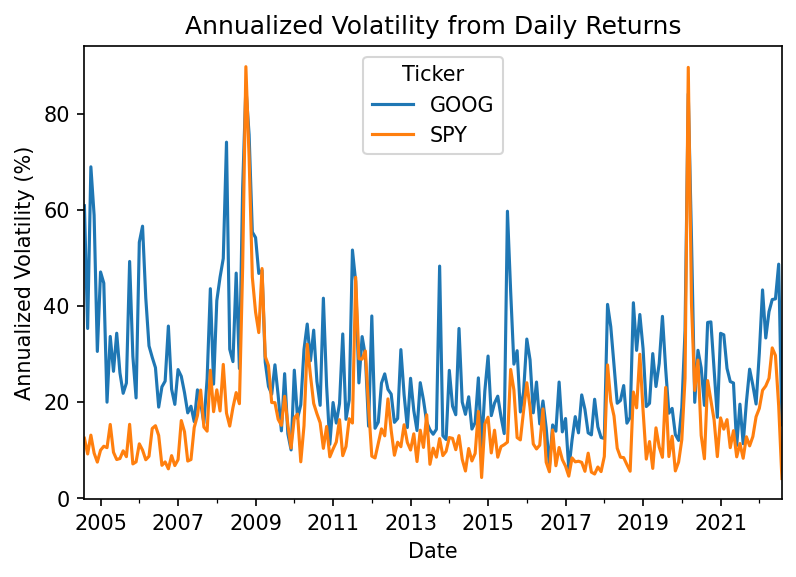

In [54]:
vol1.dropna().mul(100 * np.sqrt(252)).plot()
plt.ylabel('Annualized Volatility (%)')
plt.title('Annualized Volatility from Daily Returns')
plt.show()

In a few days, we will learn how to more easily perform this aggregation with the `.resample()` method.
Still, `pd.Grouper()` is a great to tool to know because you may want to aggregate along several dimensions, which is not possible with the `.resample()` method.

In [55]:
vol2 = ret1.resample('M').std() 

In [56]:
np.allclose(vol1, vol2, equal_nan=True)

True

***Practice:***

1. Download the daily factor data from Ken French's website
1. Calculate daily market returns by summing the market risk premium and risk-free rates (`Mkt-RF` and `RF`, respectively)
1. Calculate the volatility (standard deviation) of daily returns *every month* by combining `pd.Grouper()` and `.groupby()`)
1. Multiply by $\sqrt{252}$ to annualize these volatilities of daily returns
1. Plot these annualized volatilities

Is market volatility higher during wars?
Consider the following dates:

1. WWII: December 1941 to September 1945
1. Korean War: 1950 to 1953
1. Viet Nam War: 1959 to 1975
1. Gulf War: 1990 to 1991
1. War in Afghanistan: 2001 to 2021

In [57]:
pdr.famafrench.get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

In [58]:
ff = pdr.get_data_famafrench('F-F_Research_Data_Factors_daily', start='1900-01-01', session=session)[0] / 100

In [59]:
ff['Mkt'] = ff['Mkt-RF'] + ff['RF']

In [60]:
vol3 = ff['Mkt'].groupby(pd.Grouper(freq='M')).std()

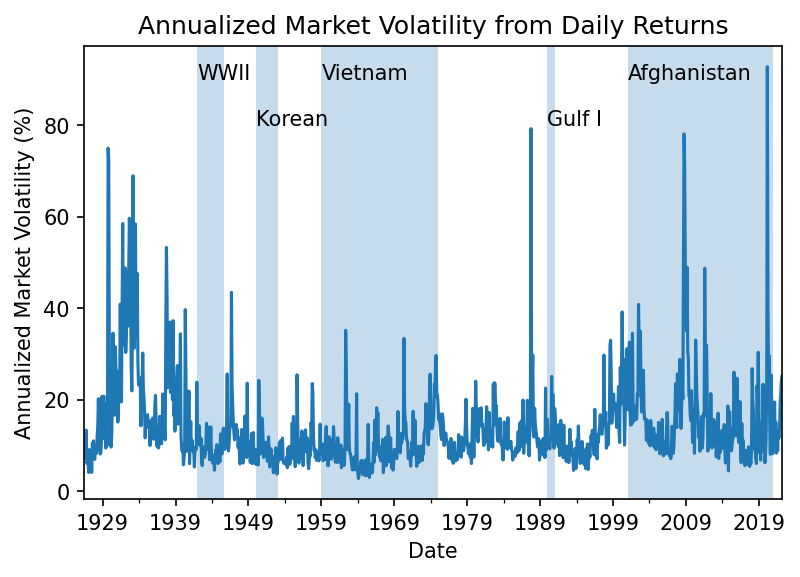

In [61]:
vol3.dropna().mul(100 * np.sqrt(252)).plot()
plt.axvspan('1941-12', '1945-09', alpha=0.25)
plt.annotate('WWII', ('1941-12', 90))
plt.axvspan('1950', '1953', alpha=0.25)
plt.annotate('Korean', ('1950', 80))
plt.axvspan('1959', '1975', alpha=0.25)
plt.annotate('Vietnam', ('1959', 90))
plt.axvspan('1990', '1991', alpha=0.25)
plt.annotate('Gulf I', ('1990', 80))
plt.axvspan('2001', '2021', alpha=0.25)
plt.annotate('Afghanistan', ('2001', 90))
plt.ylabel('Annualized Market Volatility (%)')
plt.title('Annualized Market Volatility from Daily Returns')
plt.show()

---

# Pivot Tables and Cross-Tabulation

Above we manually made pivot tables with the `groupby()`, `.agg()`, `.apply()` and `.unstack()` methods.
pandas provides a literal interpreation of Excel-style pivot tables with the `.pivot_table()` method and the `pandas.pivot_table()` function.
These also provide row and column totals via "margins".
It is worthwhile to read-through the `.pivot_table()` docstring several times.

In [62]:
faang.loc['2015':].pivot_table(index='Ticker')

Variable,Adj Close,Close,High,Low,Open,Return,Volume
Ticker,,,,,,,
AAPL,67.2926,68.8137,69.5381,68.0209,68.7630,0.0011,134444078.6276
AMZN,87.0249,87.0249,88.0340,85.9845,87.0645,0.0013,83425670.6129
FB,184.0675,184.0675,186.2677,181.7562,184.0207,0.0006,22988940.0236
GOOG,66.0515,66.0515,66.6990,65.3688,66.0230,0.0009,33245411.8135
NFLX,288.6858,288.6858,293.0689,284.0453,288.7013,0.0012,9854050.4453


In [63]:
faang.loc['2015':].reset_index().pivot_table(index=[pd.Grouper(key='Date', freq='A')], columns=['Ticker'], values=['Return'])

Variable    Return                                
Ticker        AAPL    AMZN      FB    GOOG    NFLX
Date                                              
2015-12-31  0.0000  0.0033  0.0013  0.0016  0.0039
2016-12-31  0.0006  0.0006  0.0005  0.0001  0.0007
2017-12-31  0.0016  0.0019  0.0018  0.0013  0.0019
2018-12-31 -0.0001  0.0013 -0.0009  0.0001  0.0018
2019-12-31  0.0027  0.0009  0.0019  0.0011  0.0010
2020-12-31  0.0028  0.0025  0.0015  0.0014  0.0025
2021-12-31  0.0013  0.0002  0.0010  0.0021  0.0006
2022-12-31 -0.0005 -0.0009 -0.0042 -0.0012 -0.0055

In [64]:
faang.loc['2015':].reset_index().pivot_table(index=[pd.Grouper(key='Date', freq='A')], columns=['Ticker'], values=['Return'], aggfunc=['mean', 'std'])

mean                                    std                \
Variable    Return                                 Return                 
Ticker        AAPL    AMZN      FB    GOOG    NFLX   AAPL   AMZN     FB   
Date                                                                      
2015-12-31  0.0000  0.0033  0.0013  0.0016  0.0039 0.0168 0.0211 0.0162   
2016-12-31  0.0006  0.0006  0.0005  0.0001  0.0007 0.0147 0.0187 0.0179   
2017-12-31  0.0016  0.0019  0.0018  0.0013  0.0019 0.0111 0.0132 0.0107   
2018-12-31 -0.0001  0.0013 -0.0009  0.0001  0.0018 0.0181 0.0227 0.0240   
2019-12-31  0.0027  0.0009  0.0019  0.0011  0.0010 0.0165 0.0144 0.0176   
2020-12-31  0.0028  0.0025  0.0015  0.0014  0.0025 0.0294 0.0243 0.0289   
2021-12-31  0.0013  0.0002  0.0010  0.0021  0.0006 0.0158 0.0152 0.0186   
2022-12-31 -0.0005 -0.0009 -0.0042 -0.0012 -0.0055 0.0219 0.0338 0.0413   

                          
Variable                  
Ticker       GOOG   NFLX  
Date                      
2015-12-31 0.0186 0.0319  
2016-12-31 0.0126 0.0281  
2017-12-31 0.0097 0.0176  
2018-12-31 0.0177 0.0292  
2019-12-31 0.0152 0.0218  
2020-12-31 0.0241 0.0291  
2021-12-31 0.0149 0.0202  
2022-12-31 0.0247 0.0492

In [65]:
faang.loc['2015':].reset_index().pivot_table(index=[pd.Grouper(key='Date', freq='A')], columns=['Ticker'], values=['Return'], aggfunc=['mean', 'std'])

mean                                    std                \
Variable    Return                                 Return                 
Ticker        AAPL    AMZN      FB    GOOG    NFLX   AAPL   AMZN     FB   
Date                                                                      
2015-12-31  0.0000  0.0033  0.0013  0.0016  0.0039 0.0168 0.0211 0.0162   
2016-12-31  0.0006  0.0006  0.0005  0.0001  0.0007 0.0147 0.0187 0.0179   
2017-12-31  0.0016  0.0019  0.0018  0.0013  0.0019 0.0111 0.0132 0.0107   
2018-12-31 -0.0001  0.0013 -0.0009  0.0001  0.0018 0.0181 0.0227 0.0240   
2019-12-31  0.0027  0.0009  0.0019  0.0011  0.0010 0.0165 0.0144 0.0176   
2020-12-31  0.0028  0.0025  0.0015  0.0014  0.0025 0.0294 0.0243 0.0289   
2021-12-31  0.0013  0.0002  0.0010  0.0021  0.0006 0.0158 0.0152 0.0186   
2022-12-31 -0.0005 -0.0009 -0.0042 -0.0012 -0.0055 0.0219 0.0338 0.0413   

                          
Variable                  
Ticker       GOOG   NFLX  
Date                      
2015-12-31 0.0186 0.0319  
2016-12-31 0.0126 0.0281  
2017-12-31 0.0097 0.0176  
2018-12-31 0.0177 0.0292  
2019-12-31 0.0152 0.0218  
2020-12-31 0.0241 0.0291  
2021-12-31 0.0149 0.0202  
2022-12-31 0.0247 0.0492

We can improve code readability by wrapping a line of code in `()` and inserting line breaks.